# Mixture Density Networks in TensorFlow
An implementation of MDNs adapted from Andrej Karpathy's [example](https://github.com/karpathy/randomfun). My version is powered by [TensorFlow](https://www.tensorflow.org/versions/master/get_started/index.html)

Mixture Density Networks are just like vanilla neural networks but they return estimates of uncertainty on their predictions. Karpathy writes:

"The core idea is to have a Neural Net that predicts an entire (and possibly complex)
distribution. In this example we're predicting a mixture of gaussians distributions via
its sufficient statistics (the means and diagonal covariances), which are on the last
layer of the neural network. This means that the network knows what it doesn't know:
it will predict diffuse distributions in situations where the target variable is very
noisy, and it will predict a much more peaky distribution in nearly deterministic parts."

Karpathy took his version from Bishop's Machine Learning textbook (1994)

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

sess = tf.InteractiveSession()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10bc8e210>> ignored


In [12]:
#the function we'll be trying to predict
N = 200
X = np.linspace(0,1,N)
Y = X + 0.3 * np.sin(2*3.1415926*X) + np.random.uniform(-0.1, 0.1, N)
X,Y = Y,X
# plt.scatter(X,Y,color='g')

In [13]:
#hyperparameters
input_size = 1 #size of input (x)
output_size = 1
hidden_size = 30 # size of hidden layer
M = 3 #number of mixture components
batch_size = 200

## Initialize tensors for weights and biases
I store them all in a dictionary so that they are easier to pass to functions

In [14]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.25)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

x = tf.placeholder("float", shape=[None, input_size]) #[nb x 1]
y = tf.placeholder("float", shape=[None, output_size]) #[nb x 1]

w = {}
w['Wxh'] = weight_variable([input_size, hidden_size]) # [input x hidden]
w['Whu'] = weight_variable([hidden_size, M]) #[hidden x M]
w['Whs'] = weight_variable([hidden_size, M]) #[hidden x M]
w['Whp'] = weight_variable([hidden_size, M]) #[hidden x M]

w['bxh'] = bias_variable([1, hidden_size]) # [1 x hidden]
w['bhu'] = bias_variable([1, M]) # [1 x M]
w['bhs'] = bias_variable([1, M]) # [1 x M]
w['bhp'] = bias_variable([1, M]) # [1 x M]

## Build the computation graph
All the variables are tensorflow types. (ps = probabilities, lp = log probabilities, loss = log loss)

In [15]:
h = tf.nn.tanh(tf.matmul(x, w['Wxh']) + w['bxh']) #[nb x hidden]
mu = tf.matmul(h, w['Whu']) + w['bhu']  #[nb x M]
sigma = tf.exp( tf.matmul(h, w['Whs']) + w['bhs'] )  #[nb x M]
pi = tf.nn.softmax( tf.matmul(h, w['Whp']) + w['bhp'] )  #[nb x M]

ps = tf.exp(-(tf.pow(y-mu,2))/(2*tf.pow(sigma,2)))/(sigma*np.sqrt(2*math.pi)) #[nb x M]
pin = ps * pi
lp = -tf.log(tf.reduce_sum(pin, 1, keep_dims=True)) #[nb x 1] (sum across dimension 1)
loss = tf.reduce_sum(lp) / batch_size # scalar

In [16]:
#select training data (1 batch, all data)
nb = N # full batch
xbatch = np.reshape(X[:nb], (nb,1))
ybatch = np.reshape(Y[:nb], (nb,1))

## Optimize
Use TensorFlow's built-in optimization methods. Training loss should hit about -1 after 20,000 steps

In [17]:
train_step = tf.train.AdagradOptimizer(1e-2).minimize(loss)
sess.run(tf.initialize_all_variables())

for i in range(20000):
    if i%1000 == 0:
        train_loss = loss.eval(feed_dict={x:xbatch, y: ybatch})
        print "step %d, training loss %g"%(i, train_loss)
    train_step.run(feed_dict={x: xbatch, y: ybatch})

print "training loss %g"%loss.eval(feed_dict={x:xbatch, y: ybatch})

step 0, training loss 0.97247
step 1000, training loss -0.709157
step 2000, training loss -0.802351
step 3000, training loss -0.855826
step 4000, training loss -0.896237
step 5000, training loss -0.923585
step 6000, training loss -0.941037
step 7000, training loss -0.952521
step 8000, training loss -0.960583
step 9000, training loss -0.966559
step 10000, training loss -0.971154
step 11000, training loss -0.974751
step 12000, training loss -0.977597
step 13000, training loss -0.979862
step 14000, training loss -0.981674
step 15000, training loss -0.983125
step 16000, training loss -0.984289
step 17000, training loss -0.985222
step 18000, training loss -0.985971
step 19000, training loss -0.986574
training loss -0.98706


## Sample
Sample from the mixture density network (in attempt to reproduce original function)

In [18]:

def sample(mus, sigmas, pis):
    best = pis.argmax(axis = 1)  #[nb x 1]
    print best.shape
    
    #select the best
    indices = np.zeros_like(mus) #[nb x M]
    indices[range(mus.shape[0]), best] = 1
    
    best_mus = np.sum( np.multiply(indices, mus), axis=1)
    best_sigmas = np.sum( np.multiply(indices, sigmas), axis=1)
    
    Y_ = np.random.normal(best_mus, best_sigmas)
    return Y_

(200,)


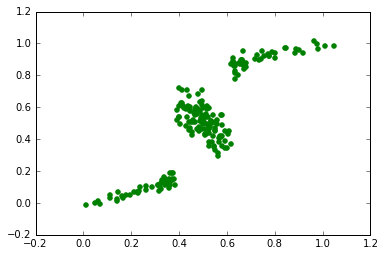

In [19]:
# plot results
X_ = xbatch
mus = mu.eval(feed_dict={x:xbatch})  #[nb x M]
sigmas = sigma.eval(feed_dict={x:xbatch})  #[nb x M]
pis = pi.eval(feed_dict={x:xbatch})  #[nb x M]
Y_ = sample(mus,sigmas,pis)
plt.scatter(X,Y_,color='g')

Results are similar to those achieved by Karpathy